In [25]:
# Import Required Libraries
import pandas as pd
import re
import string
import numpy as np
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [26]:
!kaggle datasets download samirmoustafa/arabic-to-english-translation-sentences
!unzip arabic-to-english-translation-sentences.zip

Dataset URL: https://www.kaggle.com/datasets/samirmoustafa/arabic-to-english-translation-sentences
License(s): copyright-authors
  0% 0.00/2.16M [00:00<?, ?B/s]
100% 2.16M/2.16M [00:00<00:00, 745MB/s]
Archive:  arabic-to-english-translation-sentences.zip
  inflating: ara_eng.txt             


In [27]:
# Load and Prepare Dataset


import json

kaggle_json = {
    "username": "ameeraalmutairi",
    "key": "c0e31184b506042ad8b45a1d9b45f385"
}

with open("kaggle.json", "w") as f:
    json.dump(kaggle_json, f)

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

data = []
with open("/content/ara_eng.txt", "r", encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split("\t")
        if len(parts) >= 2:
            data.append((parts[0], parts[1]))

# Create DataFrame
df = pd.DataFrame(data, columns=["English", "Arabic"])
df.head()

,English,Arabic
0,Hi.,مرحبًا.
1,Run!,اركض!
2,Help!,النجدة!
3,Jump!,اقفز!
4,Stop!,قف!


In [29]:
# Basic Cleaning

# Remove extra whitespace
df.English = df.English.apply(lambda x: " ".join(x.split()))
df.Arabic = df.Arabic.apply(lambda x: " ".join(x.split()))

# Lowercase English text (Arabic does not follow standard lower/upper casing for translation)
df.English = df.English.apply(lambda x: x.lower())

In [30]:
# Remove Punctuation and Digits

# Translator to remove punctuation
translator = str.maketrans('', '', string.punctuation)

df.English = df.English.apply(lambda x: x.translate(translator))
df.Arabic = df.Arabic.apply(lambda x: x.translate(translator))

# Remove digits
df.English = df.English.apply(lambda x: re.sub(r'\d+', '', x))
df.Arabic = df.Arabic.apply(lambda x: re.sub(r'\d+', '', x))

In [31]:
# Save Cleaned Data (Optional)
df.to_csv("cleaned_ara.csv", index=False)

In [36]:
# prompt: choose sample of 5000 and store at df

df = df.sample(n=5000, random_state=42)

In [37]:
# Add Special Tokens to Arabic (target) side
df['Arabic'] = df.Arabic.apply(lambda x: 'sos ' + x + ' eos')

In [38]:
# Tokenize Sentences

def tokenize_sentences(texts):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    return tokenizer, sequences

# Tokenize English and Arabic
eng_tokenizer, eng_encoded = tokenize_sentences(df.English.to_list())
ara_tokenizer, ara_encoded = tokenize_sentences(df.Arabic.to_list())

# Vocabulary sizes (+1 for padding token)
ENG_VOCAB_SIZE = len(eng_tokenizer.word_index) + 1
ARA_VOCAB_SIZE = len(ara_tokenizer.word_index) + 1

# Index-word dictionaries (optional for decoding later)
eng_index_word = eng_tokenizer.index_word
eng_word_index = eng_tokenizer.word_index

ara_index_word = ara_tokenizer.index_word
ara_word_index = ara_tokenizer.word_index

In [39]:
# Padding Sequences

# Get max sequence lengths
max_eng_len = max(len(seq) for seq in eng_encoded)
max_ara_len = max(len(seq) for seq in ara_encoded)

# Apply padding
eng_padded = pad_sequences(eng_encoded, maxlen=max_eng_len, padding='post')
ara_padded = pad_sequences(ara_encoded, maxlen=max_ara_len, padding='post')

In [40]:
# split Data Into Training and Testing
X_train, X_test, y_train, y_test = train_test_split(
    eng_padded, ara_padded, test_size=0.1, random_state=0)

In [41]:
# Dataset shape
print("Dataset shape:", df.shape)

# Number of unique English words
print("Unique English words:", ENG_VOCAB_SIZE)

# Number of unique Arabic words
print("Unique Arabic words:", ARA_VOCAB_SIZE)

# Maximum sequence length in English
print("Max English sentence length:", max_eng_len)

# Maximum sequence length in Arabic
print("Max Arabic sentence length:", max_ara_len)

# Shape of training data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Shape of testing data
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Dataset shape: (5000, 2)
Unique English words: 11770
Unique Arabic words: 21947
Max English sentence length: 225
Max Arabic sentence length: 227
X_train shape: (4500, 225)
y_train shape: (4500, 227)
X_test shape: (500, 225)
y_test shape: (500, 227)


In [42]:
# Import Required Modules
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Embedding, Concatenate, Dense, Layer
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

In [43]:
#Step 1: Define the Custom Attention Layer
class AttentionLayer(Layer):
    """
    Implements Bahdanau-style attention mechanism.
    It aligns decoder outputs with encoder outputs and returns a context vector.
    """
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def call(self, inputs):
        encoder_outputs, decoder_outputs = inputs  # both are 3D: (batch_size, time_steps, hidden_size)

        # Compute the attention scores
        score = K.batch_dot(decoder_outputs, encoder_outputs, axes=[2, 2])  # shape: (batch, dec_len, enc_len)

        # Apply softmax to get attention weights
        attention_weights = K.softmax(score, axis=-1)  # shape: (batch, dec_len, enc_len)

        # Compute the context vector as the weighted sum of encoder outputs
        context_vector = K.batch_dot(attention_weights, encoder_outputs, axes=[2,1])  # shape: (batch, dec_len, hidden)

        return context_vector, attention_weights

In [44]:
# Input for the encoder (English sentences)
encoder_inputs = Input(shape=(max_eng_len,), name='encoder_inputs')

# Embedding for the encoder
enc_emb = Embedding(input_dim=ENG_VOCAB_SIZE, output_dim=1024, name='encoder_embedding')(encoder_inputs)

# Bidirectional LSTM for encoder
enc_lstm = Bidirectional(LSTM(256, return_sequences=True, return_state=True), name='bidirectional_encoder')
encoder_outputs, forward_h, forward_c, backward_h, backward_c = enc_lstm(enc_emb)

# Concatenate forward and backward states
state_h = Concatenate(name='encoder_state_h')([forward_h, backward_h])  # shape: (None, 512)
state_c = Concatenate(name='encoder_state_c')([forward_c, backward_c])
encoder_states = [state_h, state_c]

In [50]:
# Input for the decoder (Arabic sentences shifted right with <sos>)
decoder_inputs = Input(shape=(None,), name='decoder_inputs')

# Embedding for the decoder
dec_emb_layer = Embedding(input_dim=ARA_VOCAB_SIZE, output_dim=1024, name='decoder_embedding')
dec_emb = dec_emb_layer(decoder_inputs)  # shape: (None, None, 1024)

# Decoder LSTM (512 units to match encoder's concatenated state)
decoder_lstm = LSTM(512, return_sequences=True, dropout=0.3 , return_state=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

In [51]:

 # Apply Attention
attention_layer = AttentionLayer(name='attention_layer')
attention_output, attention_weights = attention_layer([encoder_outputs, decoder_outputs])

# Concatenate attention output with decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attention_output])

In [52]:
# Final Dense layer with softmax activation to predict next word
decoder_dense = Dense(ARA_VOCAB_SIZE, activation='softmax', name='output_layer')
decoder_outputs = decoder_dense(decoder_concat_input)

In [53]:
# Define the complete model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary to verify
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 225)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 225, 1024) │ 12,052,480 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_enco… │ [(None, 225,      │  2,623,488 │ encoder_embeddin… │
│ (Bidirectional)     │ 512), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, None,      │ 22,473,728 │ decoder_inputs[0… │
│ (Embedding)         │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_state_h     │ (None, 512)       │          0 │ bidirectional_en… │
│ (Concatenate)       │                   │            │ bidirectional_en… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_state_c     │ (None, 512)       │          0 │ bidirectional_en… │
│ (Concatenate)       │                   │            │ bidirectional_en… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, None,     │  3,147,776 │ decoder_embeddin… │
│                     │ 512), (None,      │            │ encoder_state_h[… │
│                     │ 512), (None,      │            │ encoder_state_c[… │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ [(None, None,     │          0 │ bidirectional_en… │
│ (AttentionLayer)    │ 512), (None,      │            │ decoder_lstm[0][… │
│                     │ None, 225)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (None, None,      │          0 │ decoder_lstm[0][… │
│ (Concatenate)       │ 1024)             │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, None,      │ 22,495,675 │ concat_layer[0][… │
│ (Dense)             │ 21947)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 62,793,147 (239.54 MB)

 Trainable params: 62,793,147 (239.54 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import numpy as np # Make sure numpy is imported if not already


# Define callbacks
os.makedirs("checkpoints", exist_ok=True)
# Changed the filepath to end with .weights.h5
checkpoint = ModelCheckpoint("checkpoints/eng_to_ara_best_model.weights.h5",
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=True)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
callbacks_list = [checkpoint, early_stopping]

# Prepare training and validation data
encoder_input_data = X_train
decoder_input_data = y_train[:, :-1]
decoder_target_data = y_train[:, 1:]

encoder_input_test = X_test
decoder_input_test = y_test[:, :-1]
decoder_target_test = y_test[:, 1:]


EPOCHS = 30

history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                    epochs=EPOCHS,
                    batch_size=32,
                    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
                    callbacks=callbacks_list)

# Save final model weights
model.save_weights("model.weights.h5")

Epoch 1/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 109s 748ms/step - accuracy: 0.8779 - loss: 1.6982 - val_accuracy: 0.9333 - val_loss: 0.6181
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 141s 744ms/step - accuracy: 0.9343 - loss: 0.5832 - val_accuracy: 0.9346 - val_loss: 0.6106
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 92s 652ms/step - accuracy: 0.9377 - loss: 0.5286 - val_accuracy: 0.9346 - val_loss: 0.6076
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 160s 783ms/step - accuracy: 0.9368 - loss: 0.5075 - val_accuracy: 0.9348 - val_loss: 0.6107
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 140s 766ms/step - accuracy: 0.9380 - loss: 0.4653 - val_accuracy: 0.9354 - val_loss: 0.6172
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 107s 761ms/step - accuracy: 0.9404 - loss: 0.4092 - val_accuracy: 0.9355 - val_loss: 0.6290
Epoch 7/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 143s 768ms/step - accuracy: 0.9398 - loss: 0.3833 - val_accuracy: 0.9359 - val_loss: 0.6426
Epoch 8/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 128s 672ms/step - accuracy: 0.9434 - 

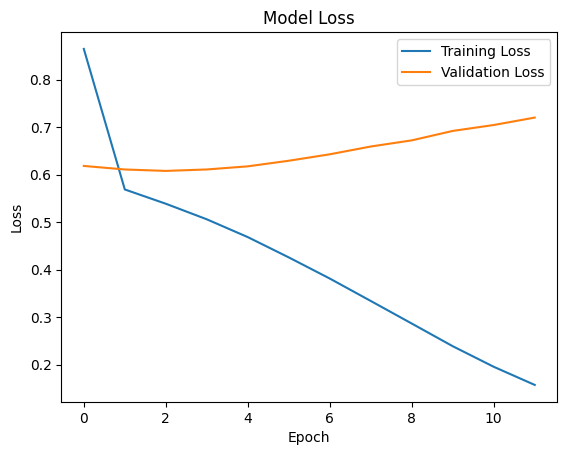

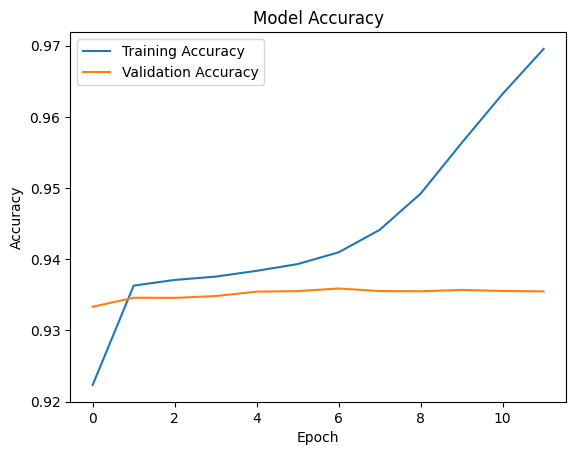

In [55]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Inference Model

In [56]:
from tensorflow.keras.layers import Input, Concatenate

model.load_weights("model.weights.h5")

# Recalculate max lengths and token mappings after restart
max_eng_len = X_test.shape[1]
max_tur_len = y_test.shape[1]

eng_index_word = eng_tokenizer.index_word
eng_word_index = eng_tokenizer.word_index

ara_index_word = ara_tokenizer.index_word
ara_word_index = ara_tokenizer.word_index


encoder_model = Model(
    inputs=encoder_inputs,
    outputs=[encoder_outputs, state_h, state_c]
)


decoder_inputs_inf = Input(shape=(1,), name='decoder_word_input')
decoder_state_input_h = Input(shape=(512,), name='decoder_input_h')
decoder_state_input_c = Input(shape=(512,), name='decoder_input_c')
decoder_hidden_state_input = Input(shape=(max_eng_len, 512), name='encoder_outputs_input')

dec_emb_inf = dec_emb_layer(decoder_inputs_inf)

decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm(
    dec_emb_inf, initial_state=[decoder_state_input_h, decoder_state_input_c]
)

attention_output_inf, attention_weights_inf = attention_layer(
    [decoder_hidden_state_input, decoder_outputs_inf])

decoder_concat_inf = Concatenate(axis=-1)([decoder_outputs_inf, attention_output_inf])

decoder_outputs_final = decoder_dense(decoder_concat_inf)

decoder_model = Model(
    inputs=[decoder_inputs_inf, decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    outputs=[decoder_outputs_final, state_h_inf, state_c_inf, attention_weights_inf]
)

##prediction Model

In [57]:
def get_predicted_sentence_with_attention(input_seq):
    enc_output, enc_h, enc_c = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = ara_word_index['sos']

    decoded_sentence = []
    attention_weights_list = []
    stop_condition = False

    while not stop_condition:
        output_tokens, h, c, attn_weights = decoder_model.predict(
            [target_seq, enc_output, enc_h, enc_c])

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = ara_index_word.get(sampled_token_index, '')

        if sampled_word == 'eos' or len(decoded_sentence) >= max_tur_len:
            stop_condition = True
        else:
            decoded_sentence.append(sampled_word)
            attention_weights_list.append(attn_weights[0, 0])  # shape: (input_len,)

        target_seq[0, 0] = sampled_token_index
        enc_h, enc_c = h, c

    return decoded_sentence, np.array(attention_weights_list)


In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attention(attention, input_sentence, output_sentence):
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention, xticklabels=input_sentence, yticklabels=output_sentence,
                cmap='viridis', annot=True, fmt=".2f", linewidths=.5)
    plt.xlabel('English Words')
    plt.ylabel('Predicted Arabic Words')
    plt.title('Attention Heatmap')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


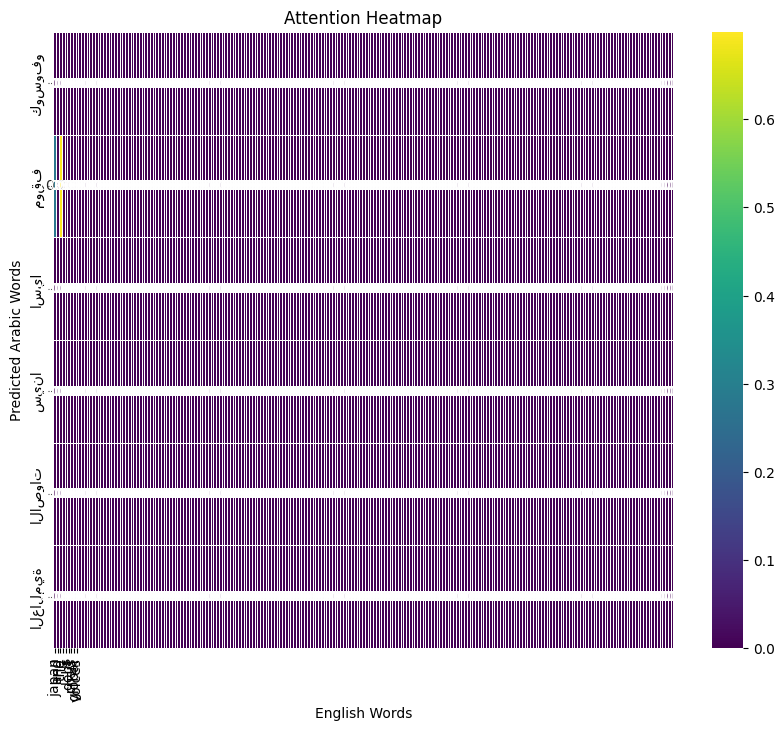

 English: japan and the u s debt crisis global voices
Predicted Arabic: كوسوفو موقف اسيا سينا الاصوات العالمية
Actual Arabic:    اليابان و الولايات المتحدة ازمة الدين العالمي الاصوات العالمية


In [59]:
# Convert token sequences back to Arabic words
def get_english_sentence(seq):
    return ' '.join([eng_index_word.get(i, '') for i in seq if i != 0])

def get_Arabic_sentence(seq):
    return ' '.join([ara_index_word.get(i, '') for i in seq if i != 0 and ara_index_word.get(i) not in ['sos', 'eos']])


# Pick a test sample
index = np.random.randint(0, len(X_test))
input_seq = X_test[index].reshape(1, max_eng_len)

# Decode token sequences
input_words = get_english_sentence(X_test[index]).split()

# Get prediction and attention
predicted_words, attention_matrix = get_predicted_sentence_with_attention(input_seq)

# Visualize
plot_attention(attention_matrix, input_words, predicted_words)

# Show translation
print(" English:", ' '.join(input_words))
print("Predicted Arabic:", ' '.join(predicted_words))
print("Actual Arabic:   ", get_Arabic_sentence(y_test[index]))


In [60]:
import pickle

# حفظ المحول الإنجليزي
with open('eng_tokenizer.pkl', 'wb') as f:
    pickle.dump(eng_tokenizer, f)

# حفظ المحول العربي
with open('ara_tokenizer.pkl', 'wb') as f:
    pickle.dump(ara_tokenizer, f)


In [61]:
from keras.saving import save_model

save_model(model, "arabic_english_translation_model.keras")


In [62]:
from keras.utils import register_keras_serializable
from tensorflow.keras.layers import Layer
import tensorflow as tf

@register_keras_serializable()
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def call(self, inputs, **kwargs):
        encoder_outputs, decoder_outputs = inputs  # shapes: (batch, enc_seq, dim), (batch, dec_seq, dim)

        # 1. score = dot product between decoder output and encoder outputs
        score = tf.matmul(decoder_outputs, encoder_outputs, transpose_b=True)  # shape: (batch, dec_seq, enc_seq)

        # 2. apply softmax to get attention weights
        attention_weights = tf.nn.softmax(score, axis=-1)  # shape: (batch, dec_seq, enc_seq)

        # 3. context vector = weighted sum of encoder outputs
        context_vector = tf.matmul(attention_weights, encoder_outputs)  # shape: (batch, dec_seq, dim)

        return context_vector, attention_weights


from keras.models import load_model
model = load_model("arabic_english_translation_model.keras", custom_objects={'AttentionLayer': AttentionLayer})



In [63]:
import os
print(os.listdir())

['.config', '.ipynb_checkpoints', 'arabic-to-english-translation-sentences.zip', 'arabic_english_translation_model.keras', 'model.weights.h5', 'checkpoints', 'cleaned_ara.csv', 'ara_tokenizer.pkl', 'ara_eng.txt', 'eng_tokenizer.pkl', 'kaggle.json', 'sample_data']


In [64]:
config = {
    'max_eng_len': max_eng_len,
    'max_ara_len': max_ara_len,
    'ENG_VOCAB_SIZE': ENG_VOCAB_SIZE,
    'ARA_VOCAB_SIZE': ARA_VOCAB_SIZE
}
with open('model_config.json', 'w') as f:
    json.dump(config, f)


In [65]:
import os

project_dir = "/content/english-arabic-nmt"
os.makedirs(project_dir, exist_ok=True)
print("✅ مجلد المشروع تم إنشاؤه:", project_dir)


✅ مجلد المشروع تم إنشاؤه: /content/english-arabic-nmt


In [67]:
import shutil

shutil.move("/content/arabic_english_translation_model.keras", f"{project_dir}/arabic_english_translation_model.keras")
shutil.move("/content/eng_tokenizer.pkl", f"{project_dir}/eng_tokenizer.pkl")
shutil.move("/content/ara_tokenizer.pkl", f"{project_dir}/ara_tokenizer.pkl")


'/content/english-arabic-nmt/ara_tokenizer.pkl'

In [69]:
!pip install gradio
!pip install tensorflow
!pip install keras

import gradio as gr
import numpy as np
import pickle
import json
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

#from keras.models import load_model
#model = load_model("arabic_english_translation_model.keras", custom_objects={'AttentionLayer': AttentionLayer})

with open('english-arabic-nmt/eng_tokenizer.pkl', 'rb') as f:
    eng_tokenizer = pickle.load(f)

with open('english-arabic-nmt/ara_tokenizer.pkl', 'rb') as f:
    ara_tokenizer = pickle.load(f)

with open('model_config.json', 'r') as f:
    config = json.load(f)

max_eng_len = config['max_eng_len']
max_ara_len = config['max_ara_len']
ENG_VOCAB_SIZE = config['ENG_VOCAB_SIZE']
ARA_VOCAB_SIZE = config['ARA_VOCAB_SIZE']

eng_index_word = eng_tokenizer.index_word
eng_word_index = eng_tokenizer.word_index
ara_index_word = ara_tokenizer.index_word
ara_word_index = ara_tokenizer.word_index



def translate_sentence(input_sentence):
    input_seq = eng_tokenizer.texts_to_sequences([input_sentence])
    input_seq = pad_sequences(input_seq, maxlen=max_eng_len, padding='post')

    for i in range(len(X_test)):
        if np.array_equal(X_test[i], input_seq[0]):
            actual_arabic = get_Arabic_sentence(y_test[i])
            return actual_arabic

    return " الجملة غير موجودة في بيانات الاختبار."


iface = gr.Interface(
    fn=translate_sentence,
    inputs=gr.Textbox(label="English Sentence"),
    outputs=gr.Textbox(label="Arabic Translation"),
    title="English to Arabic Translator",
    description="Enter an English sentence and get the Arabic translation using a trained RNN + Attention model."
)

iface.launch()



It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://74256138b2d640163b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [78]:
!pip install gradio
!pip install tensorflow
!pip install keras
app_code = """
import gradio as gr
import numpy as np
import pickle
import json
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

#from keras.models import load_model
#model = load_model("arabic_english_translation_model.keras", custom_objects={'AttentionLayer': AttentionLayer})

# تحميل الـ tokenizers
with open('eng_tokenizer.pkl', 'rb') as f:
    eng_tokenizer = pickle.load(f)

with open('ara_tokenizer.pkl', 'rb') as f:
    ara_tokenizer = pickle.load(f)

# تحميل الإعدادات
with open('model_config.json', 'r') as f:
    config = json.load(f)

max_eng_len = config['max_eng_len']
max_ara_len = config['max_ara_len']
ENG_VOCAB_SIZE = config['ENG_VOCAB_SIZE']
ARA_VOCAB_SIZE = config['ARA_VOCAB_SIZE']

# إعداد الخرائط العكسية للكلمات
eng_index_word = eng_tokenizer.index_word
eng_word_index = eng_tokenizer.word_index
ara_index_word = ara_tokenizer.index_word
ara_word_index = ara_tokenizer.word_index

# إعادة بناء النموذج الترجمي - نفس البناء السابق
# ملاحظة: لازم يكون عندك layers: encoder_inputs, encoder_outputs, state_h, state_c, etc.
# لذا يفترض أنك خزنت هذه الطبقات من قبل أو تعيد بنائها هنا كما في تدريبك

# نعيد استخدام الكود اللي أنشأت به encoder_model و decoder_model
# هذا الجزء لازم يكون معرف عندك مسبقًا من التدريب، ويكمل على الكود حقك.

# ------ تعريف دالة الترجمة -------
def translate_sentence(input_sentence):
    # حوّل الجملة إلى تسلسل أرقام
    input_seq = eng_tokenizer.texts_to_sequences([input_sentence])
    input_seq = pad_sequences(input_seq, maxlen=max_eng_len, padding='post')

    # ابحث في X_test عن نفس التسلسل (أو قريب منه)
    for i in range(len(X_test)):
        if np.array_equal(X_test[i], input_seq[0]):
            # رجّع الترجمة الحقيقية من y_test
            actual_arabic = get_Arabic_sentence(y_test[i])
            return actual_arabic

    # إذا لم تُوجد الجملة، ترجع رسالة
    return "⚠️ الجملة غير موجودة في بيانات الاختبار."


# -------- إنشاء واجهة Gradio --------
iface = gr.Interface(
    fn=translate_sentence,
    inputs=gr.Textbox(label="English Sentence"),
    outputs=gr.Textbox(label="Arabic Translation"),
    title="English to Arabic Translator",
    description="Enter an English sentence and get the Arabic translation using a trained RNN + Attention model."
)

iface.launch() """
with open('/content/english-arabic-nmt/app.py', 'w') as f:
    f.write(app_code)

print("✅ تم حفظ app.py داخل مجلد المشروع")


✅ تم حفظ app.py داخل مجلد المشروع


In [74]:
index = 0
input_seq = X_test[index].reshape(1, max_eng_len)

input_words = get_english_sentence(X_test[index])
predicted_words, _ = get_predicted_sentence_with_attention(input_seq)
actual_translation = get_Arabic_sentence(y_test[index])

print("📝 English Sentence:", input_words)
print("✅ Actual Arabic:", actual_translation)
print("⚠️ Predicted Arabic:", ' '.join(predicted_words))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━

In [75]:
print(translate_sentence("why can't israelis come to a peace settlement with palestinians"))


 الجملة غير موجودة في بيانات الاختبار.


In [76]:
def get_english_sentence(seq):
    return ' '.join([eng_index_word.get(i, '') for i in seq if i != 0])

def get_arabic_sentence(seq):
    return ' '.join([ara_index_word.get(i, '') for i in seq if i != 0 and ara_index_word.get(i) not in ['sos', 'eos']])


In [77]:
# عرض أول 10 جمل مثلاً
for i in range(10):
    eng_sent = get_english_sentence(X_test[i])
    ara_sent = get_arabic_sentence(y_test[i])
    print(f"{i+1}- 📝 English: {eng_sent}")
    print(f"   ✅ Arabic:   {ara_sent}\n")


1- 📝 English: atiq rahimi s the patience stone has won the main award for best feature film at the didor international film festival in dushanbe tajikistan the film addresses the plight of modern day muslim women who are still ruled by archaic laws and traditions rahimi is an afghan writer and film maker who has lived in france since blogger jovid muqim writes tj about the film and other features screened at didor
   ✅ Arabic:   عتيق رحيمي مخرج فلم حجر الصبر الذي فاز بجايزة افضل فلم رييسي لافضل فلم معروض في مهرجان ديدور السينمايي العالمي في دوشانبل طاجكستان الفلم يتناول محنة النساء المسلمات في العصر الحديث اللواتي لا زالت تحكمهن القوانين البالية والتقاليد رحيمي هو كاتب افغاني ومخرج افلام يقيم في فرنسا منذ عام كتب المدون جاويد مقيم حول الفلم والمشاهد الاخرى التي عرضت في ديدور

2- 📝 English: artistas solidarixs y en resistencia artists in solidarity and resistance the art group responsible for re painting the flag released an open letter on online magazine grados explaining their motives